In [1]:
import cvxpy as cp # python 3.7 로 해야.... 하루종일 걸려서 발견...
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import pickle 

In [2]:
# https://skyeong.net/271
# https://www.forecaster.site/portfolio-optimization-with-python/
# https://pyportfolioopt.readthedocs.io/en/latest/index.html
#https://math.stackexchange.com/questions/1319406/maximizing-the-sharpe-ratio-by-finding-the-optimal-weights

In [3]:
df_tar = pd.read_csv("./data/Toy_data_target.csv")

In [4]:
df_tar

,Date,TLT,EMB,AGG,Cash,SPY,EFA,VWO,GLD,DBC
0,1980-01-01,NaN,NaN,1000.00000,NaN,1000.000000,1000.00000,NaN,1000.000000,NaN
1,1980-01-02,NaN,NaN,1000.00000,NaN,979.803595,1000.00000,NaN,1092.773438,NaN
2,1980-01-03,NaN,NaN,1000.00000,NaN,974.800815,1000.00000,NaN,1238.281250,NaN
3,1980-01-04,NaN,NaN,1000.00000,NaN,986.844543,1000.00000,NaN,1148.437500,NaN
4,1980-01-07,NaN,NaN,1000.00000,NaN,989.531221,1000.00000,NaN,1237.304688,NaN
...,...,...,...,...,...,...,...,...,...,...
10788,2021-05-07,10044.636410,12407.69618,18639.68512,9195.975652,79683.136810,32776.74957,17588.93250,3449.782195,3901.717983
10789,2021-05-10,9942.914377,12379.90294,18610.40217,9196.330422,78894.114390,32601.45952,17260.16018,3460.235035,3874.636158
10790,2021-05-11,9886.637481,12350.99587,18569.73844,9196.472964,78189.984420,32173.46756,17214.12733,3460.837116,3916.300121
10791,2021-05-12,9782.748695,12238.70061,18504.68865,9196.595708,76528.838200,31659.85032,16773.58338,3426.457160,3912.133177


In [5]:
# Date control 

df_tar['Date'] = df_tar.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d') )
df_tar = df_tar.set_index('Date')

In [6]:
df_tar.isna().sum()

TLT     2608
EMB     3413
AGG        0
Cash    1829
SPY        0
EFA        0
VWO     2087
GLD        0
DBC     2328
dtype: int64

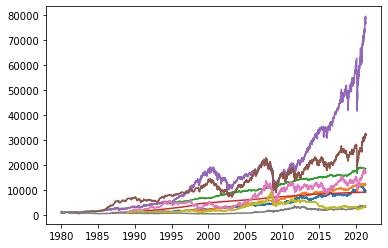

In [7]:
plt.plot(df_tar)
plt.show()

# 1990.1.1 부터 진행, x 값들의 시작이 거기부터임 

In [8]:
start_date = datetime.datetime.strptime('1990-01-01', '%Y-%m-%d')

df_tar = df_tar.loc[start_date:]

# 우선 na 다 제거한 상태로 진행 (추후 NA 값 대체)

In [9]:

df_tar = df_tar.dropna(axis=0)
df_tar.isna().sum()

TLT     0
EMB     0
AGG     0
Cash    0
SPY     0
EFA     0
VWO     0
GLD     0
DBC     0
dtype: int64

In [10]:
df_tar.index.min()

Timestamp('1993-01-29 00:00:00')

In [11]:
df_tar.index.max()

Timestamp('2021-05-13 00:00:00')

In [12]:

# df_tar = df_tar.fillna(0)
# df_tar.isna().sum()

In [13]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

In [14]:
def return_volatility(df_t):
    '''
    return & volatility
    '''  
    logret = np.log(df_t/df_t.shift(1)).dropna()
    T = logret.shape[0]

    sigma = logret.cov() * T #
    mu = logret.mean()*T
    
    return mu, sigma

In [15]:
# def return_volatility(df_t):
#     '''
#     return & volatility
#     '''  
#     #Annualized Returns calculation 
#     returns = expected_returns.mean_historical_return(df_bench)

#     #Variance of Portfolio calculation 
#     variance = risk_models.sample_cov(df_bench)
    
#     return returns, variance

In [16]:
# def MVO_sharpe(mu, sigma, rf):
#     ef = EfficientFrontier(mu, sigma, weight_bounds = (0,1))
#     ef.add_constraint(lambda x : x>=0)
#     ef.add_constraint(lambda x : x<=0.25)
    
#     # Find the tangency portfolio
#     ef.max_sharpe(risk_free_rate = rf) # risk free rate 추후 조정
#     weights = ef.clean_weights() # rounding upto 5th decimal
    
#     ret_tangent, std_tangent, _ = ef.portfolio_performance(risk_free_rate = rf, verbose = False)
#     # LABEL 
#     weights_label = np.array(list(weights.values()))
    
#     return weights_label, ret_tangent, std_tangent
    

In [17]:
def MVO_sharpe(mu, sigma, rf):
    ef = EfficientFrontier(mu, sigma, weight_bounds = (0,0.25))
    
    # Find the tangency portfolio
    ef.max_sharpe(risk_free_rate = rf) # risk free rate 추후 조정
    weights = ef.clean_weights() # rounding upto 5th decimal
    
    ret_tangent, std_tangent, _ = ef.portfolio_performance(risk_free_rate = rf, verbose = False)
    # LABEL 
    weights_label = np.array(list(weights.values()))
    
    return weights_label, ret_tangent, std_tangent
    

# Entire Dataseta

In [18]:
import copy

In [19]:
df_tar.shape

(7380, 9)

In [20]:
df_t = copy.deepcopy(df_tar)

In [21]:
# select first & last trading day of the month

first_day = []
last_day = []
count = 0

first_day.append(df_t.index[0])

prev_month = df_t.index[0].month # 1

for ind in range(len(df_t.index)):
    date = df_t.index[ind]
    
    if prev_month == 13:
        prev_month = 1
    month = date.month # current month
    
    if month != prev_month:
        count = 0
        if count == 0 :
            first_day.append(date)
            last_day.append(df_t.index[ind-1])
            
        prev_month+=1
        count+=1

# building benchmark date : fist date and last date of the month
first_last_day_dict = {}

key = [i for i in range(len(first_day))] # order number
value = list(zip(first_day, last_day))

bench_dict = dict(zip(key, value))


# All label
# duration selection 
    # past + future 1 month
    # input : bench_dict, past_duration

all_label = []

past_duration = 400
start_ind = past_duration//30

for ind in range(start_ind, len(bench_dict)):
    
    first_t = bench_dict[ind][0]
    last_t = bench_dict[ind][1]

    future = df_t[(df_t.index >= first_t) & (df_t.index <= last_t)] # one month
    past = df_t[(df_t.index >= first_t - datetime.timedelta(days = past_duration)) & (df_t.index <= first_t)]
    # concatenating future and past
    df_bench = pd.concat([past, future]).drop_duplicates()
    # expected return & volatility
#     print (df_bench)
    mu, sigma = return_volatility(df_bench)
#     print (mu)
#     print (sigma)
    # calculating weight maximizing sharpe ratio
    w, r, s = MVO_sharpe(mu,sigma, 0.00)
#     print (w)
    # all label appending
    all_label.append(w)

In [22]:
len(bench_dict) # future 1 month (first trading day & last trading day)

340

In [23]:
len(all_label) # number of total label 

327

In [24]:
class LabelGeneration():
    
    def __init__(self, df_t, rf):
        self.df_t = df_t
        self.rf = rf
    
    def return_volatility(self):
        '''
        return & volatility
        '''  
        logret = np.log(self.df_t/self.df_t.shift(1)).dropna()
        T = logret.shape[0]

        sigma = logret.cov() * T # annualize sigma (check again)
        mu = logret.mean()*T

        return mu, sigma

    def MVO_sharpe(self):
        
        mu, sigma = self.return_volatililty(self.df_t)
        ef = EfficientFrontier(mu, sigma, weight_bounds = (0, 0.25))

        # Find the tangency portfolio
        ef.max_sharpe(risk_free_rate = self.rf) # risk free rate 추후 조정
        weights = ef.clean_weights() # rounding upto 5th decimal

        ret_tangent, std_tangent, _ = ef.portfolio_performance(risk_free_rate = self.rf, verbose = False)
        # LABEL 
        weights_label = np.array(list(weights.values()))

        return weights_label, ret_tangent, std_tangent

    def bench_dict_generation(self):
        '''
        Select first & last trading day of the month
        '''
        first_day = []
        last_day = []
        count = 0
        first_day.append(self.df_t.index[0])
        prev_month = self.df_t.index[0].month # 1
        for ind in range(len(self.df_t.index)):
            date = self.df_t.index[ind]
            if prev_month == 13:
                prev_month = 1
            month = date.month # current month

            if month != prev_month:
                count = 0
                if count == 0 :
                    first_day.append(date)
                    last_day.append(self.df_t.index[ind-1])

                prev_month+=1
                count+=1

        # building benchmark date : fist date and last date of the month
        first_last_day_dict = {}
        key = [i for i in range(len(first_day))] # order number
        value = list(zip(first_day, last_day))
        bench_dict = dict(zip(key, value))
        
        return bench_dict

    def labelling(self, past_duration):
    
        all_label = []
        
        bench_dict = self.bench_dict_generation()
        start_ind = past_duration//30

        for ind in range(start_ind, len(bench_dict)):

            first_t = bench_dict[ind][0]
            last_t = bench_dict[ind][1]

            future = self.df_t[(self.df_t.index >= first_t) & (self.df_t.index <= last_t)] # one month
            past = self.df_t[(self.df_t.index >= first_t - datetime.timedelta(days = past_duration)) & (self.df_t.index <= first_t)]
            # concatenating future and past
            df_bench = pd.concat([past, future]).drop_duplicates()

            mu, sigma = return_volatility(df_bench)

            # calculating weight maximizing sharpe ratio
            w, r, s = MVO_sharpe(mu,sigma, 0.00)
      
            # all label appending
            all_label.append(w)
            
        return all_label

In [25]:
# Labelling 

rf = 0.01
label_generation = LabelGeneration(df_t, rf)

In [26]:
bench_dict = label_generation.bench_dict_generation()

In [27]:
with open("./bench_dict.pkl", 'wb') as handle:
    pickle.dump(bench_dict, handle)

### argument setting

In [28]:

past_duration = 400 # df_target 값에 대해서 어디까지 볼 것인가 
st_ind = past_duration//30
Y_label = label_generation.labelling(past_duration)

In [29]:
len(Y_label)

327

In [30]:
#Annualized Returns calculation 
returns = expected_returns.mean_historical_return(df_bench)

#Variance of Portfolio calculation 
variance = risk_models.sample_cov(df_bench)

In [31]:
mu, sigma = return_volatility(df_bench)
w,r,s = MVO_sharpe(mu, sigma,0.00)

In [32]:
mu

TLT    -0.059857
EMB     0.018279
AGG     0.027087
Cash    0.007270
SPY     0.307997
EFA     0.203138
VWO     0.215764
GLD     0.095951
DBC     0.225213
dtype: float64

In [33]:
w

array([0.00307, 0.     , 0.18426, 0.25   , 0.1923 , 0.     , 0.     ,
       0.12036, 0.25   ])

In [34]:
bench_dict[st_ind]

(Timestamp('1994-02-01 00:00:00'), Timestamp('1994-02-28 00:00:00'))

In [35]:
len(Y_label)

327

In [36]:
class MVO_sharpe():
    
    def __init__(self, mu, sigma, rf):
        self.mu = mu
        self.sigma = sigma
        self.rf = rf
    
        self.ef = EfficientFrontier(self.mu,self.sigma)
        self.ef.add_constraint(lambda x : x>=0)
        self.ef.add_constraint(lambda x : x<=0.25)
        
        self.weights, self.ret_tangent, self.std_tangent = self.solve_Markowitz_model()
    
    def solve_Markowitz_model(self):
        
        # Find the tangency portfolio
        self.ef.max_sharpe(risk_free_rate = self.rf) # risk free rate 추후 조정
        weights = self.ef.clean_weights() #rounding upto 5th decimal

        ret_tangent, std_tangent, _ = self.ef.portfolio_performance(risk_free_rate = self.rf, verbose = True)
        
        return weights, ret_tangent, std_tangent
    
    def draw_efficient_frontier(self):
        
        fig, ax = plt.subplots()
        plotting.plot_efficient_frontier(self.ef, ax=ax, show_assets=False)

        ax.scatter(self.std_tangent, self.ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

        # Generate random portfolios
        n_samples = 10000
        w = np.random.dirichlet(np.ones(len(self.mu)), n_samples)
        rets = w.dot(self.mu)
        stds = np.sqrt(np.diag(w @ self.sigma @ w.T))
        sharpes = rets / stds # assumes r_f is 0
        ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

        # Output
        ax.set_title("Efficient Frontier with random portfolios")
        ax.legend()
        plt.tight_layout()
        plt.show()

In [37]:
rf = 0.02
mvo = MVO_sharpe(mu, sigma, rf)

Expected annual return: 15.3%
Annual volatility: 14.4%
Sharpe Ratio: 0.93


In [54]:
mvo.sigma

,TLT,EMB,AGG,Cash,SPY,EFA,VWO,GLD,DBC
TLT,5.116412e-02,0.003815,1.250442e-02,-4.051600e-07,-0.031780,-0.027692,-0.024338,0.008190,-0.014115
EMB,3.814981e-03,0.041254,1.028544e-02,-1.257344e-05,0.046902,0.047306,0.050702,0.010477,0.028166
AGG,1.250442e-02,0.010285,7.683725e-03,-6.889892e-07,0.005261,0.006529,0.006392,0.005044,0.003349
Cash,-4.051600e-07,-0.000013,-6.889892e-07,1.929957e-07,-0.000002,-0.000003,-0.000007,0.000010,-0.000014
SPY,-3.177958e-02,0.046902,5.260671e-03,-1.606427e-06,0.116089,0.099892,0.099723,0.013237,0.047053
EFA,-2.769163e-02,0.047306,6.528933e-03,-2.898126e-06,0.099892,0.102265,0.096738,0.014795,0.045353
VWO,-2.433849e-02,0.050702,6.392306e-03,-6.599071e-06,0.099723,0.096738,0.116509,0.016079,0.048432
GLD,8.190337e-03,0.010477,5.043745e-03,1.034104e-05,0.013237,0.014795,0.016079,0.045282,0.011838
DBC,-1.411460e-02,0.028166,3.348854e-03,-1.429727e-05,0.047053,0.045353,0.048432,0.011838,0.057796


In [49]:
mu

TLT    -0.059857
EMB     0.018279
AGG     0.027087
Cash    0.007270
SPY     0.307997
EFA     0.203138
VWO     0.215764
GLD     0.095951
DBC     0.225213
dtype: float64

Expected annual return: 11.2%
Annual volatility: 10.5%
Sharpe Ratio: 1.25


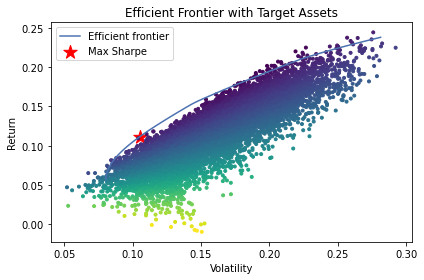

In [53]:
ef = EfficientFrontier(mu,sigma)
ef.add_constraint(lambda x : x>=0)
ef.add_constraint(lambda x : x<=0.25)


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Solve the problem : Find the tangency portfolio
ef.max_sharpe(risk_free_rate = -0.02) # risk free rate 추후 조정
weights = ef.clean_weights() #rounding upto 5th decimal
ret_tangent, std_tangent, _ = ef.portfolio_performance(risk_free_rate = rf, verbose = True)


ax.scatter(std_tangent, ret_tangent, marker="*", s=200, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ sigma @ w.T))
sharpes = (rets-rf) / stds # assumes r_f is 0
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with Target Assets")
ax.legend()
plt.tight_layout()
plt.show()